Не стал пересчитывать вложения с учетом инфляции, так как хотел посмотреть не только на первоначальные вложения, но и на распределение их по балансу.
В процентах боялся запутаться, но думаю что если учесть инфляцию, то результат просто станет лучше.

In [874]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV, SGDRegressor, LogisticRegressionCV, LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import preprocessing
from tqdm.notebook import tqdm
from autoviz.AutoViz_Class import AutoViz_Class
import datetime
from time import sleep, time
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [875]:
RANDOM_SEED = 42

In [876]:
# def na_info(ds: pd.DataFrame) -> pd.DataFrame:
#     arr = []
#     nans_cnt = ds.isna().sum()
#     for ind, row in tqdm(nans_cnt.items(), total=nans_cnt.shape[0]):
#         name = ind
#         if ind.startswith('ind_'):
#             name = buh_codes_dict[ind[4:8]]
#         arr.append([ind, name, row, round(row / data.shape[0] * 100, 2)])
#     return pd.DataFrame(arr, columns=['column', 'name', 'nan_cnt', 'nan_perc'])


def show_num_corr(df: pd.DataFrame, features: list = None, title: str ='Корреляция между данными'):
    '''
    Корреляция между числовыми признаками набора данных
    :param df: Набор данных
    :param features: признаки
    :param title: Заголовок карты
    :return: Корр карта признаков
    '''
    plt.figure(figsize=(16, 16))
    show_df =  df
    if features is not None:
        show_df = df[features]
    mask = np.triu(np.ones_like(show_df.corr(), dtype=bool))
    heatmap = sns.heatmap(show_df.corr(),
                          mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap = heatmap.set_title(title, fontdict={'fontsize': 18}, pad=16)
    return heatmap


def get_high_coreleted_features(df: pd.DataFrame, limit: float = 0.9, method: str = 'pearson') -> pd.DataFrame:
    '''
    Получить сильно скоррелированные признаки
    :param df: Набор данных
    :param limit: только те, корреляция которых превышает лимит
    :param method: метод вычисления корреляции
    :return: Наобор вида (признак1, признак2, коэфф корреляции)
    '''
    corr_ds = df.corr(method=method)
    corr_rows = []
    for ind_row, row in corr_ds.iterrows():
        for ind_col, cell in row.items():
            if abs(cell) > limit and ind_row != ind_col:
                if [ind_col, ind_row, cell] not in corr_rows:
                    corr_rows.append([ind_row, ind_col, cell])
    return pd.DataFrame(corr_rows, columns=['feature_1', 'feature_2', 'value'])


def outliers(df: pd.DataFrame, feature: str, iqrs: float = 1.5) -> pd.DataFrame:
    '''
    Получение выбросов по интерквартильному размаху
    :param df: Набор данных
    :param feature: Признак для которого ищем выбросы
    :param iqrs: Все что выходит за  IQR * iqrs
    :return: набор данных с выбросами
    '''
    # Интерквартильный размах
    perc25 = df[feature].quantile(0.25)
    perc75 = df[feature].quantile(0.75)
    IQR = perc75 - perc25
    low, high = (perc25 - iqrs * IQR, perc75 + iqrs * IQR)
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, Границы выбросов: [{low}, {high}]')
    return df[(df[feature] < low) | (df[feature] > high)]


def first_look(s: pd.Series) -> None:
    '''
    EDA для признаков
    :param s: Колонка признака
    :return: None
    '''
    saved_format = pd.options.display.float_format
    pd.options.display.float_format = '{:.2f}'.format
    print('-' * 80)
    try:
        print('Название:', s.name)
        print('Тип данных:', s.dtype.type)
        print('Количество значений:', len(s))
        print('Количество уникальных значений:', s.nunique())
        print('Количество пропусков:', s.isna().sum())
        print(f'Процент пропусков: {round((s.isna().sum() / len(s)) * 100, 2)}%')
        print('Общие статистики:')
        print(s.describe())
        print('Топ 10 уникальных значений:')
        print(s.value_counts()[:10])
    except Exception as e:
        print('Ошибка:', str(e))
    print('-' * 80)
    pd.options.display.float_format = saved_format


def plot_feature_importances(fi, columns: list, num: int=20) -> None:
    '''
    График важности признаков для моделей с feature_importances
    :param fi: feature_importances
    :param columns: какие признаки смотрим
    :param num: сколько самых важных выводим
    :return: None
    '''
    plt.rcParams['figure.figsize'] = (10, 10)
    feat_importances = pd.Series(fi, index=columns)
    mean_imp = feat_importances.nlargest(num).mean()
    feat_colors = feat_importances.apply(lambda x: 'r' if x > mean_imp else 'b')
    feat_importances.nlargest(num).plot(kind='barh', title='Feature importance')


def show_roc_auc(y_test: list, probs: list) -> None:
    '''
    График ROC AUC
    :param y_test: Истенные значения
    :param probs: Предсказанные вероятности
    :return: None
    '''
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.figure(figsize=(12, 8))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()


def show_lr_Importance(model: LogisticRegression, features: list, n: int=20) -> None:
    '''
    График важности признаков для моделей с LR
    :param model: экземпляр LR
    :param features: какие признаки смотрим
    :param n: сколько самых важных выводим
    :return:
    '''
    lr_coef = pd.DataFrame(model.coef_.T, columns=['coefficient'], index=features)
    lr_coef = np.abs(lr_coef)
    lr_coef = lr_coef.sort_values(by='coefficient', ascending=False)
    f, ax = plt.subplots(1, 1, figsize=(16, 10))
    df4display = lr_coef.head(n)
    sns.barplot(x=df4display['coefficient'], y=df4display.index, palette="vlag", ax=ax)
    _ = ax.set_ylabel("Признак")
    _ = ax.set_title("Значимость признаков")


def show_confusion_matrix(y_pred: list, y_true: list) -> None:
    '''
    Матрица смежности для предсказаний классификатора
    :param y_pred: предсказанные значения
    :param y_true: истинные значения
    :return:
    '''
    plt.figure(figsize=(8, 8))
    c_matrix = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    heatmap = sns.heatmap(c_matrix, annot=True, cmap='BrBG', fmt='g', annot_kws={"fontsize": 18})
    heatmap = heatmap.set_title("Confusion matrix", fontdict={'fontsize': 18}, pad=16)


def print_clssification_metrix(y_pred: list, y_true: list):
    '''
    Метрики качества для классификатора
    :param y_pred:
    :param y_true:
    :return:
    '''
    print('Precision:', metrics.precision_score(y_pred, y_true))
    print('Recall:', metrics.recall_score(y_pred, y_true))
    print('F1-score:', metrics.f1_score(y_pred, y_true))


In [877]:
def combine_equals(df):
    # Есть странные колонки заканчивающиеся на .1 и .2 - объединяем с нормальным кодом
    for col in [c for c in df.columns if c.endswith('.1') or c.endswith('.2')]:
        if col[0:8] in df.columns :
            df[col[0:8]] = df[col[0:8]] + df[col]
            df.drop(col, axis=1, inplace=True)

In [878]:
data_msk = pd.read_csv('data/df_moscow_all_upd.csv')
combine_equals(data_msk)
data_msk.head()

,inn,ogrn,main_okved,name,address,type,status,okved,date_reg,comments,...,founding_year,founding_month,name_okved,currency,inflation_by_2022,investments,inflation,total_profit,breaking_even,payback_time
0,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,67.0349,1.3200,20155.000000,1.0538,0,0,-1
1,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,58.3529,1.2527,21239.338735,1.0252,0,0,-1
2,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,62.7078,1.2218,21774.570269,1.0427,0,0,-1
3,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,64.7362,1.1718,22704.345558,1.0305,0,0,-1
4,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,72.1464,1.1371,23396.829332,1.0491,0,0,-1


In [879]:
data_spb = pd.read_csv('data/df_spb_all_upd.csv')
combine_equals(data_spb)
data_spb.head()

,inn,ogrn,main_okved,name,address,type,status,okved,date_reg,comments,...,founding_year,founding_month,name_okved,currency,inflation_by_2022,investments,inflation,total_profit,breaking_even,payback_time
0,7813213777,1157847038062,62.01,"ООО ""СТИЛЬ""","194044, г. Санкт-Петербург, пр-кт Большой Сампсониевский, 47 литер а, кв. 107",коммерческая,в процессе ликвидации,"['26.20', '26.51.8', '62.02', '62.09', '63.11', '63.11.1']",2015-02-06,Организация находится в стадии ликвидидации с 12.10.2021.,...,2015,2,Разработка компьютерного программного обеспечения,60.9579,1.4904,10.000000,1.1291,22,1,1
1,7813213777,1157847038062,62.01,"ООО ""СТИЛЬ""","194044, г. Санкт-Петербург, пр-кт Большой Сампсониевский, 47 литер а, кв. 107",коммерческая,в процессе ликвидации,"['26.20', '26.51.8', '62.02', '62.09', '63.11', '63.11.1']",2015-02-06,Организация находится в стадии ликвидидации с 12.10.2021.,...,2015,2,Разработка компьютерного программного обеспечения,67.0349,1.3200,11.291000,1.0538,57,1,1
2,7813213777,1157847038062,62.01,"ООО ""СТИЛЬ""","194044, г. Санкт-Петербург, пр-кт Большой Сампсониевский, 47 литер а, кв. 107",коммерческая,в процессе ликвидации,"['26.20', '26.51.8', '62.02', '62.09', '63.11', '63.11.1']",2015-02-06,Организация находится в стадии ликвидидации с 12.10.2021.,...,2015,2,Разработка компьютерного программного обеспечения,58.3529,1.2527,11.898456,1.0252,148,1,1
3,7813213777,1157847038062,62.01,"ООО ""СТИЛЬ""","194044, г. Санкт-Петербург, пр-кт Большой Сампсониевский, 47 литер а, кв. 107",коммерческая,в процессе ликвидации,"['26.20', '26.51.8', '62.02', '62.09', '63.11', '63.11.1']",2015-02-06,Организация находится в стадии ликвидидации с 12.10.2021.,...,2015,2,Разработка компьютерного программного обеспечения,62.7078,1.2218,12.198297,1.0427,430,1,1
4,7813213777,1157847038062,62.01,"ООО ""СТИЛЬ""","194044, г. Санкт-Петербург, пр-кт Большой Сампсониевский, 47 литер а, кв. 107",коммерческая,в процессе ликвидации,"['26.20', '26.51.8', '62.02', '62.09', '63.11', '63.11.1']",2015-02-06,Организация находится в стадии ликвидидации с 12.10.2021.,...,2015,2,Разработка компьютерного программного обеспечения,64.7362,1.1718,12.719164,1.0305,677,1,1


In [880]:
data_msk.drop(list(set(data_msk.columns).symmetric_difference(set(data_spb.columns))), axis=1, inplace=True, errors='ignore')
data_spb.drop(list(set(data_msk.columns).symmetric_difference(set(data_spb.columns))), axis=1, inplace=True, errors='ignore')
set(data_msk.columns).symmetric_difference(set(data_spb.columns))

set()

In [881]:
data_msk = data_msk.reindex(sorted(data_msk.columns), axis=1)
data_spb = data_spb.reindex(sorted(data_msk.columns), axis=1)
np.sum(data_msk.columns != data_spb.columns)

0

In [882]:
data_msk['region'] = 'msk'
data_spb['region'] = 'spb'
data = pd.concat([data_msk, data_spb]).reset_index(drop=True)
data.head()

,address,bankrupt,breaking_even,com_uncom,comments,currency,date_reg,founding_month,founding_year,ind_1100,...,name,name_okved,ogrn,okved,payback_time,status,total_profit,type,year,region
0,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",67.0349,2016-02-15,2,2016,11796,...,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,Образование высшее,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2016,msk
1,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",58.3529,2016-02-15,2,2016,11338,...,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,Образование высшее,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2017,msk
2,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",62.7078,2016-02-15,2,2016,10748,...,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,Образование высшее,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2018,msk
3,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",64.7362,2016-02-15,2,2016,10261,...,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,Образование высшее,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2019,msk
4,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",72.1464,2016-02-15,2,2016,9735,...,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,Образование высшее,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2020,msk


In [883]:
#data = pd.read_csv('data/df_spb_all_upd.csv')

In [884]:
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85684 entries, 0 to 85683
Data columns (total 122 columns):
 #    Column             Non-Null Count  Dtype  
---   ------             --------------  -----  
 0    address            85684 non-null  object 
 1    bankrupt           85684 non-null  int64  
 2    breaking_even      85684 non-null  int64  
 3    com_uncom          85684 non-null  int64  
 4    comments           16310 non-null  object 
 5    currency           85684 non-null  float64
 6    date_reg           85684 non-null  object 
 7    founding_month     85684 non-null  int64  
 8    founding_year      85684 non-null  int64  
 9    ind_1100           85684 non-null  int64  
 10   ind_1110           85684 non-null  int64  
 11   ind_1120           85684 non-null  int64  
 12   ind_1130           85684 non-null  int64  
 13   ind_1140           85684 non-null  int64  
 14   ind_1150           85684 non-null  int64  
 15   ind_1160           85684 non-null  int64  
 16   in

In [885]:
# Сразу типмизируем, чтоб не путаться
data['inn'] = data['inn'].astype(str)
data['ogrn'] = data['ogrn'].astype(str)
data['main_okved'] = data['main_okved'].astype(str)
data['name'] = data['name'].astype(str)
data['address'] = data['address'].astype(str)
data['type'] = data['type'].astype(str)
data['status'] = data['status'].astype(str)
#data['okved'] = data['okved'].apply(lambda x: x[1:-1].split(','))
data['date_reg'] = pd.to_datetime(data['date_reg'])
data['comments'] = data['comments'].astype(str)
data['year'] = data['year'].astype(int)
data[[c for c in data.columns if c.startswith('ind_')]] = data[[c for c in data.columns if c.startswith('ind_')]].astype(float)
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85684 entries, 0 to 85683
Data columns (total 122 columns):
 #    Column             Non-Null Count  Dtype         
---   ------             --------------  -----         
 0    address            85684 non-null  object        
 1    bankrupt           85684 non-null  int64         
 2    breaking_even      85684 non-null  int64         
 3    com_uncom          85684 non-null  int64         
 4    comments           85684 non-null  object        
 5    currency           85684 non-null  float64       
 6    date_reg           85684 non-null  datetime64[ns]
 7    founding_month     85684 non-null  int64         
 8    founding_year      85684 non-null  int64         
 9    ind_1100           85684 non-null  float64       
 10   ind_1110           85684 non-null  float64       
 11   ind_1120           85684 non-null  float64       
 12   ind_1130           85684 non-null  float64       
 13   ind_1140           85684 non-null  float64  

In [886]:
for col in [c for c in data.columns if c.startswith('ind_')]:
    data[col] = data[col] / data['currency']

In [887]:
# Берем все признаки из самого раннего года организации - объединяем с основным набором
additional_features = [c for c in data.columns if c.startswith('ind_')]
additional_features.remove('ind_1600')
additional_features.remove('ind_2400')
investments = data.sort_values(by=['inn', 'year']).groupby('inn').first()[['year', 'ind_1600'] + additional_features]
investments.columns = ['inv_year', 'inv_sum'] + ['inv_' + x for x in additional_features]
data.drop(investments.columns, axis=1, inplace=True, errors='ignore')
data = data.join(investments, on=['inn'])
data[['inn', 'year'] + investments.columns.tolist()].head() #.sort_values(by=['inn', 'year']).head()

,inn,year,inv_year,inv_sum,inv_ind_1100,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,...,inv_ind_4500,inv_ind_6100,inv_ind_6220,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400
0,7721452574,2016,2016,300.664281,175.968041,0.119341,0.0,0.0,0.0,351.697399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7721452574,2017,2016,300.664281,175.968041,0.119341,0.0,0.0,0.0,351.697399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7721452574,2018,2016,300.664281,175.968041,0.119341,0.0,0.0,0.0,351.697399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7721452574,2019,2016,300.664281,175.968041,0.119341,0.0,0.0,0.0,351.697399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7721452574,2020,2016,300.664281,175.968041,0.119341,0.0,0.0,0.0,351.697399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [888]:
data.loc[data['inv_sum'] < 0, ['inv_sum', 'inn', 'date_reg']]

,inv_sum,inn,date_reg
2701,-0.159470,9731000027,2018-04-09
2702,-0.159470,9731000027,2018-04-09
2703,-0.159470,9731000027,2018-04-09
3952,-0.085686,9715309555,2017-11-29
3953,-0.085686,9715309555,2017-11-29
...,...,...,...
69613,-0.032810,7842079491,2015-12-03
69614,-0.032810,7842079491,2015-12-03
69615,-0.032810,7842079491,2015-12-03
69616,-0.032810,7842079491,2015-12-03


In [889]:
# Накопительно вычисляем сумму прибыли организации по годам - объединяем с набором
profit = data.sort_values(by=['inn', 'year']).groupby('inn').cumsum()['ind_2400']
profit.name = 'profit'
data.drop(['profit'], axis=1, inplace=True, errors='ignore')
data = data.join(profit)
data[['inn', 'year', 'ind_2400', 'profit'] + investments.columns.tolist()].sort_values(by=['inn', 'year']).head()

,inn,year,ind_2400,profit,inv_year,inv_sum,inv_ind_1100,inv_ind_1110,inv_ind_1120,inv_ind_1130,...,inv_ind_4500,inv_ind_6100,inv_ind_6220,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400
57635,1102068218,2011,130.055738,130.055738,2011,2346.141544,2309.323043,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57636,1102068218,2012,-72.202747,57.852992,2011,2346.141544,2309.323043,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57637,1102068218,2013,-74.290379,-16.437388,2011,2346.141544,2309.323043,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57638,1102068218,2014,-29.462517,-45.899905,2011,2346.141544,2309.323043,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57639,1102068218,2015,-30.676910,-76.576815,2011,2346.141544,2309.323043,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [890]:
data.sort_values(by=['inn', 'year']).groupby('inn').last()[['year', 'ind_2400', 'profit'] + investments.columns.tolist()].head()

,year,ind_2400,profit,inv_year,inv_sum,inv_ind_1100,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,...,inv_ind_4500,inv_ind_6100,inv_ind_6220,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400
inn,,,,,,,,,,,,,,,,,,,,,
1102068218,2020,-3.090937,29.351412,2011,2346.141544,2309.323043,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1650329732,2021,193.037455,298.047714,2016,30.939108,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1655298774,2020,-88.348137,777.847904,2014,181.433929,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1655300448,2020,45.269064,77.171960,2014,32.299456,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2310172571,2020,180.618853,771.819554,2013,162.647576,30.174579,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [891]:
features = ['year', 'ind_2400', 'profit', 'result',] + investments.columns.tolist()

In [892]:
# Формируем результат деятельности организации за год как разницу между первоначальным вложением и прбылью после налогов
data['result'] = data['inv_sum'] - data['profit']
data.sample(2)

,address,bankrupt,breaking_even,com_uncom,comments,currency,date_reg,founding_month,founding_year,ind_1100,...,inv_ind_6220,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400,profit,result
43742,"107078, г. Москва, ул. Новая Басманная, 19 стр. 5, эт п ком. 1",0,0,1,nan,72.1464,2016-10-31,10,2016,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-38.097738,38.097738
39937,"115280, г. Москва, ул. Ленинская Слобода, 23 стр.2",0,0,1,nan,38.4217,2011-04-25,4,2011,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.248283,-3.248283


In [893]:
# Объединяем во временный набор последние записи об организации и записи где организаци вышла в 0 плюс
# затем берем ту что была раньше
temp = pd.concat([data.sort_values(by=['inn', 'year']).groupby('inn').last(),
           data[data['result'] <= 0].sort_values(by=['inn', 'year']).groupby('inn').first()]).reset_index()
temp = temp.sort_values(by=['inn', 'year']).groupby(['inn']).first().reset_index()
temp.sample(2) #[['inn'] + features]

,inn,address,bankrupt,breaking_even,com_uncom,comments,currency,date_reg,founding_month,founding_year,...,inv_ind_6220,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400,profit,result
6442,7725305203,"115191, г. Москва, ул. 2-я Рощинская, 4, оф. 503",1,1,1,Организация ликвидирована 15.08.2019.,67.0349,2016-02-03,2,2016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.409363,-9.025150
9923,7743841158,"125130, г. Москва, ул. Нарвская, 1А корп. 3, помещ. 1",0,0,1,nan,72.1464,2011-12-30,12,2011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.124746,0.294887


In [894]:
# Формироуем таргет как разницу межу годом выхода в плюс и годом инвестирования или -1 если так и не вашли в плюс
temp['target'] = temp.apply(lambda row: -1 if row['result'] > 0 else row['year'] - row['inv_year'], axis=1)
temp.sample(2)

,inn,address,bankrupt,breaking_even,com_uncom,comments,currency,date_reg,founding_month,founding_year,...,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400,profit,result,target
5492,7722430823,"111250, г. Москва, проезд Завода Серп И Молот, 6, эт 1 оф 112 ком 11",0,0,1,nan,58.3529,2017-12-29,12,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0
10493,7802193688,"192019, г. Санкт-Петербург, ул. Седова, 11 литер а, оф. 1031",0,1,1,nan,67.0349,2014-12-25,12,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.740493,-39.480224,2


In [895]:
# В рабочий набор берем только коммерческие организации
work_df = temp.loc[temp['type'] == 'коммерческая', ['inn', 'main_okved', 'date_reg', 'inv_sum', 'target', 'region'] + ['inv_' + x for x in additional_features]]
work_df.head()

,inn,main_okved,date_reg,inv_sum,target,region,inv_ind_1100,inv_ind_1110,inv_ind_1120,inv_ind_1130,...,inv_ind_4500,inv_ind_6100,inv_ind_6220,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400
0,1102068218,62.01,2011-04-04,2346.141544,-1,msk,2309.323043,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1650329732,62.01,2016-04-25,30.939108,4,msk,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1655298774,62.01,2014-08-12,181.433929,1,msk,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1655300448,62.09,2014-09-05,32.299456,1,msk,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2310172571,62.09,2013-09-09,162.647576,5,msk,30.174579,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### EDA

In [896]:
for f in work_df.columns:
    first_look(work_df[f])

--------------------------------------------------------------------------------
Название: inn
Тип данных: <class 'numpy.object_'>
Количество значений: 16095
Количество уникальных значений: 16095
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count          16095
unique         16095
top       1102068218
freq               1
Name: inn, dtype: object
Топ 10 уникальных значений:
1102068218    1
7804528072    1
7804513164    1
7804513735    1
7804513781    1
7804513990    1
7804514697    1
7804514922    1
7804515490    1
7804515764    1
Name: inn, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Название: main_okved
Тип данных: <class 'numpy.object_'>
Количество значений: 16095
Количество уникальных значений: 66
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count     16095
unique       66
top       62.01
freq       5400
Name: 

### Feature engineering

In [897]:
work_df = work_df[work_df['inv_sum'] > 0]

In [898]:
# np.log(work_df['inv_sum']).hist(bins=100)

In [899]:
work_df['inv_sum'] = np.log(work_df['inv_sum'])

In [900]:
work_df['inv_month'] = work_df['date_reg'].dt.month

In [901]:
work_df['target'] = work_df['target'].apply(lambda x: x if x <= 5 else 5)

### Первая модель - LR

In [902]:
# Формируем X
# Масштабируем числовые признаки
X = pd.DataFrame([], index=work_df.index)
X[['inv_sum'] + ['inv_' + x for x in additional_features]] = preprocessing.StandardScaler().fit_transform(work_df[['inv_sum'] + ['inv_' + x for x in additional_features]])
X.sample(2)

,inv_sum,inv_ind_1100,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,inv_ind_1160,inv_ind_1170,inv_ind_1180,...,inv_ind_4500,inv_ind_6100,inv_ind_6220,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400
8092,0.357975,-0.010102,-0.008662,-0.026781,0.0,0.0,-0.024989,-0.013758,-0.017304,-0.031276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7700,1.738335,-0.010102,-0.008662,-0.026781,0.0,0.0,-0.024989,-0.013758,-0.017304,-0.031276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [903]:
# Кодируем категориальные признаки
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['main_okved', 'region']])
X[ohe.get_feature_names()] = ohe.transform(work_df[['main_okved', 'region']]).astype(int)
X.sample(2)

,inv_sum,inv_ind_1100,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,inv_ind_1160,inv_ind_1170,inv_ind_1180,...,x0_90.04,x0_91.01,x0_91.02,x0_91.03,x0_91.04,x0_93.1,x0_93.2,x0_94.12,x1_msk,x1_spb
4780,-0.699125,-0.010102,-0.008662,-0.026781,0.0,0.0,-0.024989,-0.013758,-0.017304,-0.031276,...,0,0,0,0,0,0,0,0,1,0
3391,0.786468,-0.010102,-0.008662,-0.026781,0.0,0.0,-0.024785,-0.013758,-0.017304,-0.031276,...,0,0,0,0,0,0,0,0,1,0


In [904]:
# В таргет берем только признак окупиться/не окупится
y = (work_df['target'] != -1).astype(int)
y.unique()

array([0, 1])

In [905]:
# Бъем на трейн - тест
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,

((13954, 165), (13954,), (11163, 165), (11163,), (2791, 165), (2791,))

In [906]:
# Теперь моделька
lr = LogisticRegressionCV(Cs=10, random_state=RANDOM_SEED, class_weight='balanced')
lr.fit(X_train, y_train)
y_prob = lr.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob[:, 1])

0.6962368301265597

В принципе результат не плохой - можно работать дальше

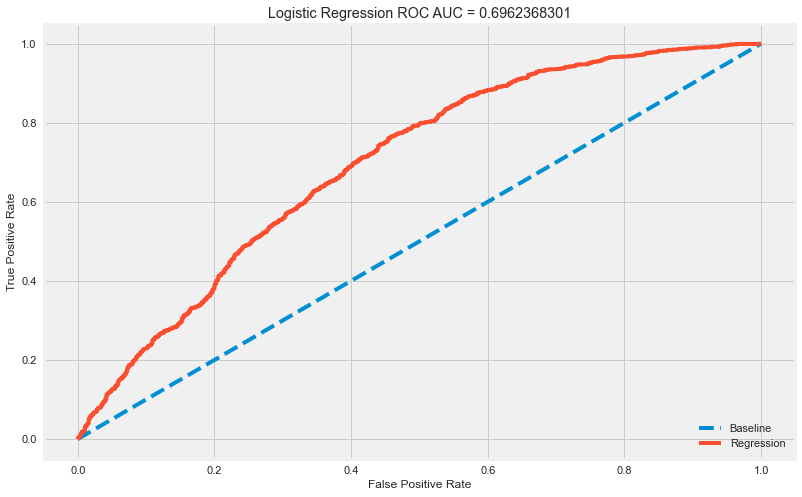

In [907]:
show_roc_auc(y_valid, y_prob[:, 1])

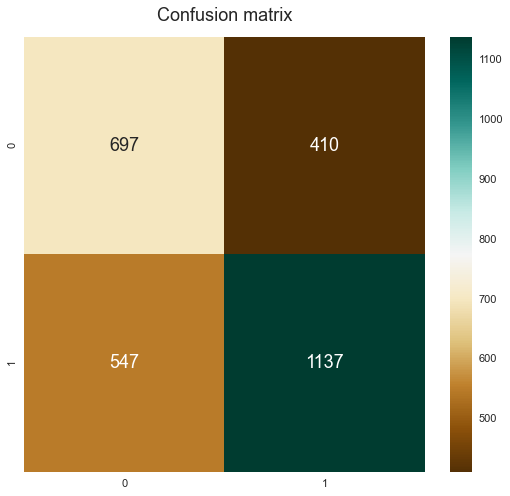

In [908]:
y_pred = lr.predict(X_valid)
show_confusion_matrix(y_valid, y_pred)

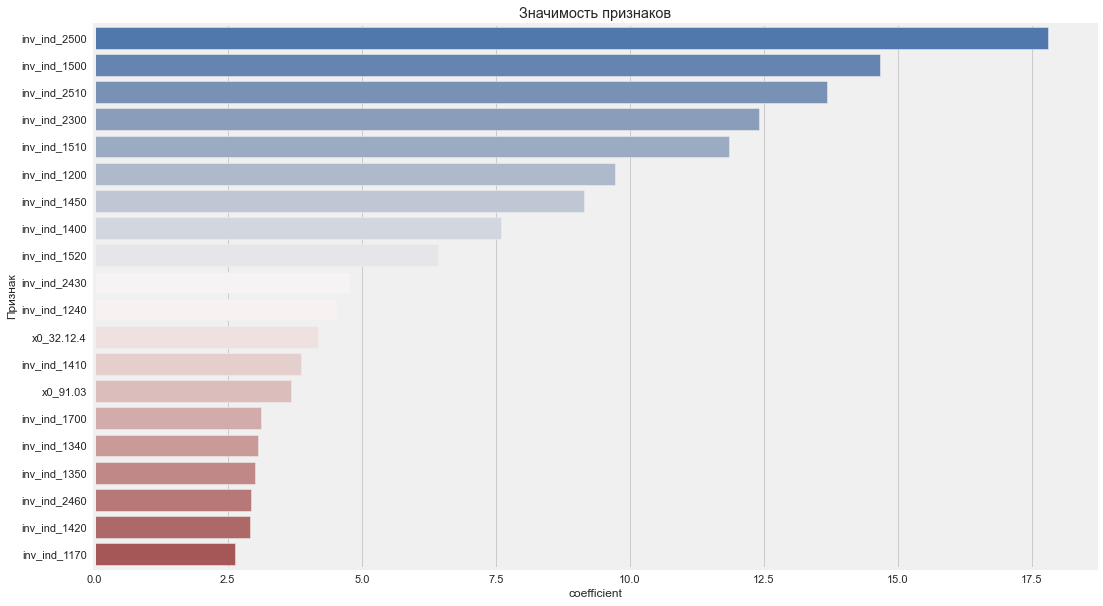

In [909]:
show_lr_Importance(lr, X.columns)

In [910]:
# По замечаниям - проверка на переобучение
y_prob = lr.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob[:, 1])

0.6963480138195586

### LGBMClassifier

In [911]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced', max_depth=3)
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob[:, 1])

0.728602138357198

Результат еще лучше, но нас интересует не просто выйдет или нет из убытков, а срок

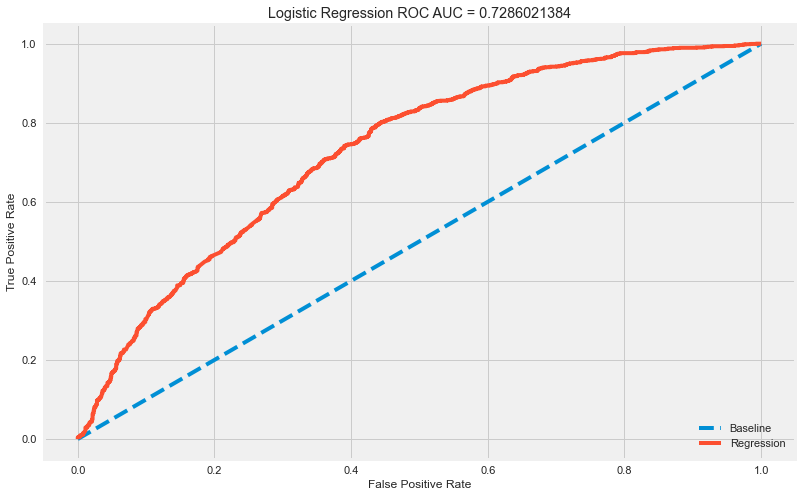

In [912]:
show_roc_auc(y_valid, y_prob[:, 1])

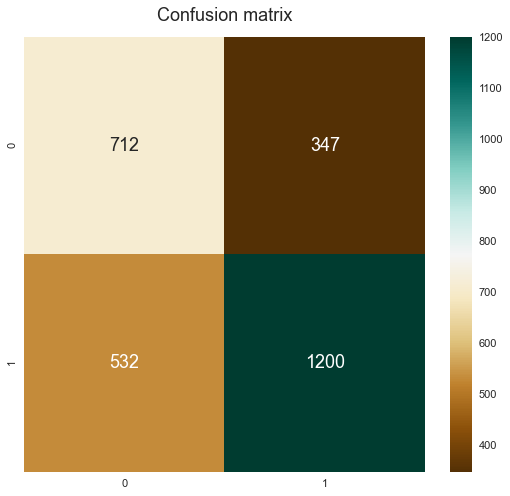

In [913]:
y_pred = model.predict(X_valid)
show_confusion_matrix(y_valid, y_pred)

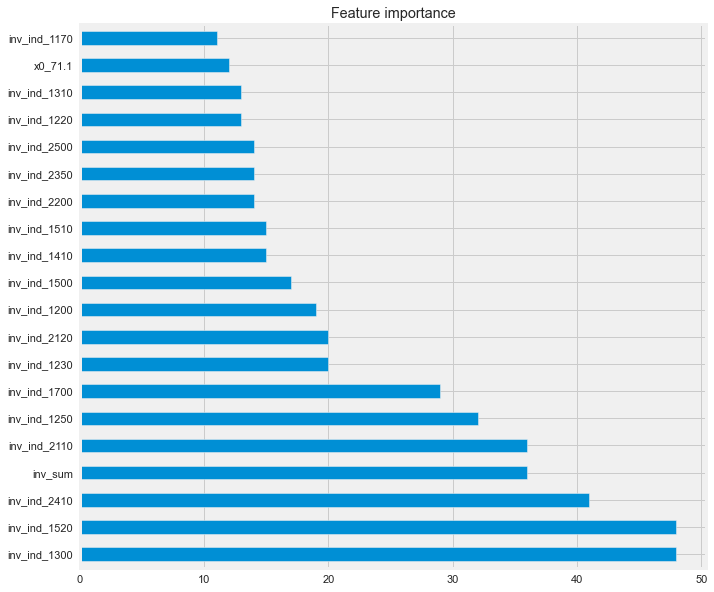

In [914]:
plot_feature_importances(model.feature_importances_, X.columns)

In [915]:
# По замечаниям - проверка на переобучение
y_prob = model.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob[:, 1])

0.7799610107798344

# !!! переобучились

### Предсказание срока выхода из убытков

In [916]:
# Можно попробовать разный набор фичей, но для начала возьмем сумму инвестиций и ОКВЕД
features = ['inv_sum']
#features = ['inv_sum', 'inv_ind_1500', 'inv_ind_1200', 'inv_ind_1300', 'inv_ind_1400']
X = pd.DataFrame([], index=work_df.index)
X[features] = preprocessing.StandardScaler().fit_transform(work_df[features])
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['main_okved', 'region']])
X[ohe.get_feature_names()] = ohe.transform(work_df[['main_okved', 'region']]).astype(int)
y = work_df['target']
X.shape, y.shape

((13954, 69), (13954,))

In [917]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,

((13954, 69), (13954,), (11163, 69), (11163,), (2791, 69), (2791,))

In [918]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced', max_depth=3)
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob, multi_class='ovr', average='weighted')

0.6412580134104108

In [919]:
cross_val_score(model, X, y, cv=5, scoring='roc_auc_ovr_weighted')

array([0.63445197, 0.62255827, 0.61781599, 0.54184542, 0.56944765])

In [920]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
for train_index, test_index in skf.split(X, y):
    model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced')
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)
    print(metrics.roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted'))
#cross_val_score(model, X, y, cv=5, scoring='roc_auc_ovo_weighted')

0.6014477854720442
0.6111161517384709
0.6113934923657817
0.5986247635810111
0.6100901234664882


На самом деле для такого набора признаков и модели без настроенных гиперпараметров результат просто поразительный, следовательно нужно искать где
в предыдущих раскладках ошибка

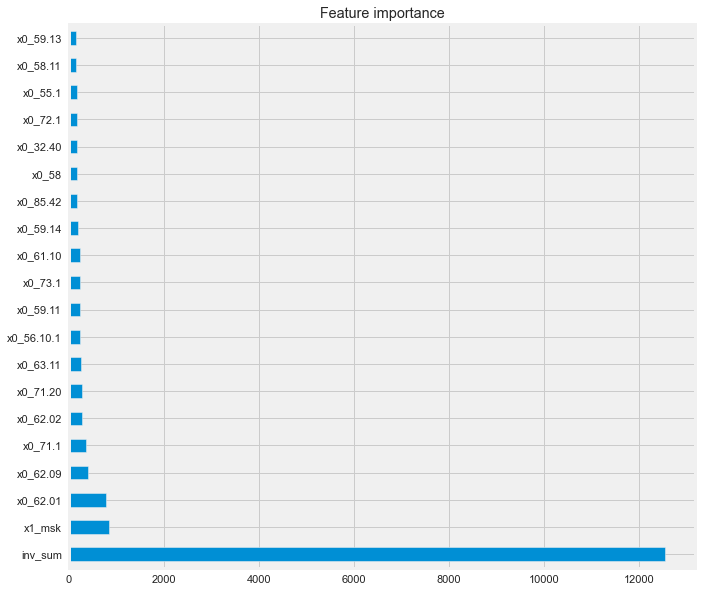

In [921]:
plot_feature_importances(model.feature_importances_, X.columns)

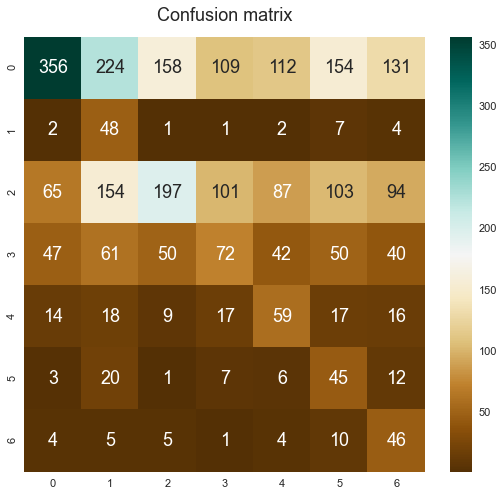

In [922]:
y_pred = model.predict(X_valid)
show_confusion_matrix(y_pred, y_valid)

In [923]:
list(zip(y_pred, y_valid))[100:110]

[(2, -1),
 (-1, 1),
 (3, 1),
 (0, -1),
 (3, -1),
 (5, 1),
 (-1, -1),
 (5, 5),
 (3, -1),
 (0, 1)]

In [924]:
# По замечаниям - проверка на переобучение
y_prob = model.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob, multi_class='ovr', average='weighted')

0.7210580284680599

# !!!Переобучились

In [925]:
model = LGBMRegressor(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
metrics.mean_absolute_error(y_valid, y_pred)

1.2421971580692979

In [926]:
list(zip(np.round(y_pred), y_valid))[100:110]

[(1.0, -1),
 (-0.0, 1),
 (0.0, 1),
 (1.0, -1),
 (1.0, -1),
 (1.0, 1),
 (0.0, -1),
 (2.0, 5),
 (-0.0, -1),
 (1.0, 1)]

In [927]:
np.unique(np.round(y_pred), return_counts=True)

(array([-1.,  0.,  1.,  2.]), array([  56, 1226, 1400,  109]))